This notebook creates visualizations of the human annotations for all the six NLP tasks.

* Input: 'AgoraSpeech_preprocessed.csv'
* Output: 'correlations.png', 'criticim_agenda.png', 'entities_horizontal_bars.png', 'entities_wordcloud_simple.png', 'entities_wordcloud.png', 'polarization.png', 'populism.png', 'sentiment.png', topics_grouped_bars.png', and 'topics_horizontal_bars.png'
* Actions: It creates visualizations for answering the following questions (corresponds to the six NLP tasks):
    1. Do politicians focus on presenting their agenda or on criticizing their opponents?
    2. In what topics are politicians' campaign speeches focused on?
    3. What is the prevalent sentiment in politicians’ speeches?
    4. To what extent are politicians’ speeches polarized?
    5. Do politicians’ speeches exhibit populism?
    6. Do politicians often refer to specific entities?

In [1]:
import warnings
import numpy as np
import pandas as pd
from PIL import Image
import plotly.express as px
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud
warnings.filterwarnings('ignore')
import plotly.graph_objects as go
import matplotlib.colors as mcolors
from scipy.stats import spearmanr, chi2_contingency

In [2]:
# read data
data = pd.read_csv('AgoraSpeech_preprocessed.csv')

Do politicians focus on presenting their agenda or on criticizing their opponents?

In [3]:
# prepare the data for the plot
df_grouped = data.groupby(['politician', 'criticism_or_agenda_human']).size().reset_index(name='count')
df_grouped['total_per_politician'] = df_grouped.groupby('politician')['count'].transform('sum')
df_grouped['proportion'] = round(df_grouped['count'] / df_grouped['total_per_politician'],2)
df_grouped.drop(columns=['count', 'total_per_politician'], inplace=True)

# plot the grouped bars
color_map = {'Mitsotakis': '#007dea', 'Tsipras': '#ef4393', 'Androulakis': '#00cc44', 'Koutsoumpas': '#ff4d4d', 'Velopoulos': '#5cb2e5', 'Varoufakis': '#fd9347'}
fig = px.bar(df_grouped, x='criticism_or_agenda_human', y='proportion', color='politician', text='proportion', barmode='group', color_discrete_map=color_map,
             labels={'proportion': 'Fraction of paragraphs', 'criticism_or_agenda_human': 'Criticim vs. Agenda'}, text_auto=True)
fig.update_traces(textposition='outside', textfont=dict(size=14, family='Arial'))

# plot the lines (overall statistics)
fig.add_shape(
    type="line",
    x0=-0.45, x1=0.45, y0=0.39, y1=0.39,
    line=dict(color="#666666", width=3, dash="dash"),
    xref="x", yref="y")
fig.add_shape(
    type="line",
    x0=0.55, x1=1.45, y0=0.60, y1=0.60,
    line=dict(color="#666666", width=3, dash="dash"),
    xref="x", yref="y")
fig.add_trace(go.Scatter(
        x=[None], y=[None],
        mode='lines',
        line=dict(color="#666666", width=3, dash="dash"),
        showlegend=True, name='Overall'))

# adjust legend and figure size
fig.update_layout(
    width=1100, height=500,
    legend_title_text='Politicians',
    legend=dict(orientation="h", yanchor="bottom", y=1.0, xanchor="center", x=0.5, font=dict(size=16, family='Arial')))

# adjust axis
fig.update_xaxes(title_font=dict(size=18, family='Arial', color='black'),
    tickfont=dict(size=16, family='Arial', color='black'))
fig.update_yaxes( title_font=dict(size=18, family='Arial', color='black'))

fig.show()
fig.write_image("images/criticism_agenda.png", scale=2)

In what topics are politicians' campaign speeches focused on?

In [4]:
# prepare the data for the plot
topic_count = data['topic_human'].value_counts(normalize=True).reset_index()
topic_count.columns = ['topic_human', 'count']
topic_count['count'] = round(topic_count['count'], 3)
topic_top20 = topic_count.head(20)

# plot the horizontal bars
cmap = mcolors.LinearSegmentedColormap.from_list('custom_blues', ['#4575b4', '#b5c9e3'], N=20)
custom_colors = [mcolors.to_hex(cmap(i/19)) for i in range(20)]
fig = px.bar(topic_top20, x='count', y='topic_human', orientation='h',
             labels={'count': 'Fraction  of paragraphs ', 'topic_human': 'Topic'}, 
             color='topic_human', color_discrete_sequence=custom_colors, text='count')
fig.update_layout(showlegend=False, yaxis={'categoryorder':'total ascending'}, width=1100, height=500)
fig.update_traces(textposition='outside', textfont=dict(size=14, family='Arial'))

# adjust axis
fig.update_xaxes(title_font=dict(size=18, family='Arial', color='black'))
fig.update_yaxes(title_font=dict(size=18, family='Arial', color='black'),
                 tickfont=dict(size=14, family='Arial', color='black'))

fig.show()
fig.write_image("images/topics_horizontal_bars.png", scale=2)

In [5]:
# prepare the data for the plot
top_topics = data['topic_human'].value_counts().head(5).index
filtered_data = data[data['topic_human'].isin(top_topics)]
grouped_data = filtered_data.groupby(['politician', 'topic_human']).size().reset_index(name='count')
grouped_data

total_rows_per_politician = data.groupby('politician').size().reset_index(name='total_rows')
grouped_data = pd.merge(grouped_data, total_rows_per_politician, on='politician')
grouped_data['normalized_count'] = round(grouped_data['count']/grouped_data['total_rows'],2)

# plot the grouped bars
color_map = {'Mitsotakis': '#007dea', 'Tsipras': '#ef4393', 'Androulakis': '#00cc44', 'Koutsoumpas': '#ff4d4d', 'Velopoulos': '#5cb2e5', 'Varoufakis': '#fd9347'}

fig = px.bar(grouped_data, x='topic_human', y='normalized_count', color='politician', text='normalized_count', barmode='group', color_discrete_map=color_map,
             labels={'normalized_count': 'Fraction of paragraphs', 'topic_human': 'Topic'}, category_orders={'topic_human': ['elections', 'economy', 'employment']}, text_auto=True)
fig.update_traces(textposition='outside', textfont=dict(size=14, family='Arial'))

# adjust legend and figure size
fig.update_layout(width=1100, height=500,legend_title_text='Politicians',
    legend=dict(orientation="h", yanchor="bottom", y=1.0, xanchor="center", x=0.5, font=dict(size=16, family='Arial')))

# adjust axis
fig.update_xaxes(title_font=dict(size=18, family='Arial', color='black'),
    tickfont=dict(size=16, family='Arial', color='black'))
fig.update_yaxes( title_font=dict(size=18, family='Arial', color='black'))

fig.show()
fig.write_image("images/topics_grouped_bars.png", scale=2)

What is the prevalent sentiment in politicians' speeches?

In [6]:
# prepare the data for the plot
df_grouped = data.groupby(['politician', 'sentiment_human_category']).size().reset_index(name='count')
df_grouped['total_per_politician'] = df_grouped.groupby('politician')['count'].transform('sum')
df_grouped['proportion'] = round(df_grouped['count'] / df_grouped['total_per_politician'],2)
df_grouped.drop(columns=['count', 'total_per_politician'], inplace=True)

# calculate the overall statistics
overall_sentiment = data.groupby('sentiment_human_category').size().reset_index(name='count')
overall_sentiment['total'] = overall_sentiment['count'].sum()
overall_sentiment['proportion'] = round(overall_sentiment['count'] / overall_sentiment['total'], 2)


# plot the grouped bars
color_map = {'Overall': '#666666','Mitsotakis': '#007dea', 'Tsipras': '#ef4393', 'Androulakis': '#00cc44', 'Koutsoumpas': '#ff4d4d', 'Velopoulos': '#5cb2e5', 'Varoufakis': '#fd9347'}
fig = px.bar(df_grouped, x='sentiment_human_category', y='proportion', color='politician', text='proportion', barmode='group', color_discrete_map=color_map,
             labels={'proportion': 'Fraction of paragraphs', 'sentiment_human_category': 'Sentiment level'}, text_auto=True)
fig.update_traces(textposition='outside', textfont=dict(size=14, family='Arial'))

# plot the lines (overall statistics)
fig.add_shape(
    type="line",
    x0=-0.45, x1=0.45, y0=overall_sentiment['proportion'].iloc[0], y1=overall_sentiment['proportion'].iloc[0],
    line=dict(color="#666666", width=3, dash="dash"),
    xref="x", yref="y")
fig.add_shape(
    type="line",
    x0=0.55, x1=1.45, y0=overall_sentiment['proportion'].iloc[1], y1=overall_sentiment['proportion'].iloc[1],
    line=dict(color="#666666", width=3, dash="dash"),
    xref="x", yref="y")
fig.add_shape(
    type="line",
    x0=1.55, x1=2.45, y0=overall_sentiment['proportion'].iloc[2], y1=overall_sentiment['proportion'].iloc[2],
    line=dict(color="#666666", width=3, dash="dash"),
    xref="x", yref="y")
fig.add_trace(go.Scatter(
        x=[None], y=[None],
        mode='lines',
        line=dict(color="#666666", width=3, dash="dash"),
        showlegend=True, name='Overall'))

# adjust legend and figure size
fig.update_layout(
    width=1100, height=500,
    legend_title_text='Politicians',
    legend=dict(orientation="h", yanchor="bottom", y=1.0, xanchor="center", x=0.5, font=dict(size=16, family='Arial')))

# adjust axis
fig.update_xaxes(title_font=dict(size=18, family='Arial', color='black'),
    tickfont=dict(size=16, family='Arial', color='black'))
fig.update_yaxes( title_font=dict(size=18, family='Arial', color='black'))

fig.show()
fig.write_image("images/sentiment.png", scale=2)

To what extent are politicians' speeches polarized?

In [7]:
def adjust_proportions(group):
    group['proportion'] = group['proportion'].round(2)
    diff = 1.00 - group['proportion'].sum()
    if diff != 0:
        group.loc[group['proportion'].idxmax(), 'proportion'] += diff
    return group

In [8]:
# prepare the data for the plot
df_grouped = data.groupby(['politician', 'polarization_human_category']).size().reset_index(name='count')
df_grouped['total_per_politician'] = df_grouped.groupby('politician')['count'].transform('sum')
df_grouped['proportion'] = df_grouped['count']/df_grouped['total_per_politician']
df_grouped = df_grouped.groupby('politician').apply(adjust_proportions)
df_grouped.drop(columns=['count', 'total_per_politician'], inplace=True)

# plot the stacked bars
color_map = {'low': '#74add1', 'medium': '#fee090', 'high': '#f46d43'}
fig = px.bar(df_grouped, x='politician', y='proportion', color='polarization_human_category',
             barmode='stack', color_discrete_map=color_map, text='proportion',
             labels={'proportion': 'Fraction of paragraphs', 'politician': 'Politician'},
             category_orders={'polarization_human_category': ['low', 'medium', 'high']}, text_auto=True)
fig.update_layout(uniformtext_minsize=12, uniformtext_mode='hide')
fig.update_traces(textposition='inside', textfont=dict(size=12, family='Arial'))

# adjust legend and figure size
fig.update_layout(
    width=750, height=500,
    legend_title_text='Polarization level',
    legend=dict(orientation="h", yanchor="bottom", y=1.01, xanchor="center", x=0.5, font=dict(size=16, family='Arial')))

# adjust axis
fig.update_xaxes(title_font=dict(size=18, family='Arial', color='black'),
    tickfont=dict(size=16, family='Arial', color='black'))
fig.update_yaxes(title_font=dict(size=18, family='Arial', color='black'))

fig.show()
fig.write_image("images/polarization.png", scale=2)

Do politicians' speeches exhibit populism?

In [9]:
# prepare the data for the plot
df_grouped = data.groupby(['politician', 'populism_human_category']).size().reset_index(name='count')
df_grouped['total_per_politician'] = df_grouped.groupby('politician')['count'].transform('sum')
df_grouped['proportion'] = df_grouped['count']/df_grouped['total_per_politician']
df_grouped = df_grouped.groupby('politician').apply(adjust_proportions)
df_grouped.drop(columns=['count', 'total_per_politician'], inplace=True)

# plot the stacked bars
color_map = {'low': '#74add1', 'medium': '#fee090', 'high': '#f46d43'}
fig = px.bar(df_grouped, x='politician', y='proportion', color='populism_human_category',
             barmode='stack', color_discrete_map=color_map, text='proportion',
             labels={'proportion': 'Fraction of paragraphs', 'politician': 'Politician'},
             category_orders={'populism_human_category': ['low', 'medium', 'high']}, text_auto=True)
fig.update_layout(uniformtext_minsize=12, uniformtext_mode='hide')
fig.update_traces(textposition='inside', textfont=dict(size=12, family='Arial'))

# adjust legend and figure size
fig.update_layout(
    width=750, height=500,
    legend_title_text='Populism level',
    legend=dict(orientation="h", yanchor="bottom", y=1.01, xanchor="center", x=0.5, font=dict(size=16, family='Arial')))

# adjust axis
fig.update_xaxes(title_font=dict(size=18, family='Arial', color='black'),
    tickfont=dict(size=16, family='Arial', color='black'))
fig.update_yaxes(title_font=dict(size=18, family='Arial', color='black'))

fig.show()
fig.write_image("images/populism.png", scale=2)

Do politicians often refer to specific entities?

In [10]:
import ast

data['entity_specific_human'] = data['entity_specific_human'].apply(lambda x: ast.literal_eval(x))

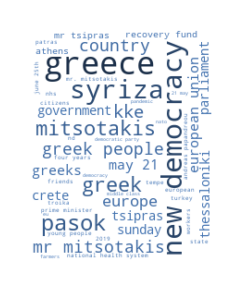

In [12]:
# prepare the data for the plot
all_entities = [entity for sublist in data['entity_specific_human'] for entity in sublist]
entity_counts = Counter(all_entities)
top_20_entities = entity_counts.most_common(50)
word_freq = dict(top_20_entities)

# create the color mapping
cmap = mcolors.LinearSegmentedColormap.from_list('custom_blues', ['#4678b9', '#1c304a'], N=50)
custom_colors = [mcolors.to_hex(cmap(i/49)) for i in range(50)]
min_freq = min(word_freq.values())
max_freq = max(word_freq.values())
def color_func(word, font_size, position, orientation, random_state=None, **kwargs):
    frequency = word_freq[word]
    normalized_freq = (frequency - min_freq) / (max_freq - min_freq)
    r, g, b, a = cmap(normalized_freq)
    return f"rgb({int(r*255)}, {int(g*255)}, {int(b*255)})"

# plot the wordcloud
wordcloud = WordCloud(width=200, height=250, background_color="white").generate_from_frequencies(word_freq)
wordcloud = wordcloud.recolor(color_func=color_func)

# save with high resolution
plt.figure(figsize=(2,1), dpi=300)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.savefig("images/entities_wordcloud_simple.png", dpi=300, bbox_inches='tight', pad_inches=0)

In [13]:
# prepare the data for the plot
expanded_data = data.explode('entity_specific_human')
entity_politician_count = expanded_data.groupby(['entity_specific_human', 'politician']).size().reset_index(name='count')
top_20_entities = expanded_data['entity_specific_human'].value_counts().nlargest(20).index
entity_politician_count = entity_politician_count[entity_politician_count['entity_specific_human'].isin(top_20_entities)]
entity_total_count = entity_politician_count.groupby('entity_specific_human')['count'].sum().reset_index(name='total_count')
sorted_entities = entity_total_count.sort_values(by='total_count', ascending=False)['entity_specific_human'].to_list()

# plot the horizontal bars
color_map = {'Overall': '#666666','Mitsotakis': '#007dea', 'Tsipras': '#ef4393', 'Androulakis': '#00cc44', 'Koutsoumpas': '#ff4d4d', 'Velopoulos': '#5cb2e5', 'Varoufakis': '#fd9347'}
fig = px.bar(entity_politician_count, x='count', y='entity_specific_human',  barmode='stack',
             orientation='h', color='politician', color_discrete_map=color_map, category_orders={'entity_specific_human': sorted_entities},
             labels={'count': 'Occurrence of entities', 'entity_specific_human': 'Entity', 'politician': 'Politician'})

# adjust legend and figure size
fig.update_layout(
    width=1000, height=500,
    legend=dict(orientation="h", yanchor="bottom", y=1.0, xanchor="center", x=0.5, font=dict(size=16, family='Arial')))

# adjust axis
fig.update_xaxes(title_font=dict(size=18, family='Arial', color='black'))
fig.update_yaxes(title_font=dict(size=18, family='Arial', color='black'),
                 tickfont=dict(size=14, family='Arial', color='black'))

fig.show()
fig.write_image("images/entities_horizontal_bars.png", scale=2)

CORRELATIONS

In [14]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    r, k = confusion_matrix.shape
    return np.sqrt(chi2 / (n * (min(r, k) - 1)))

In [15]:
# prepare the data for the plot
data_correlations = data[['criticism_or_agenda_human', 'topic_human', 'sentiment_human', 'polarization_human', 'populism_human', 'entity_specific_human']]
data_correlations.rename(columns={'criticism_or_agenda_human': 'criticism or agenda', 'topic_human': 'topic', 'sentiment_human': 'sentiment', 
                                  'polarization_human': 'polarization', 'populism_human': 'populism', 'entity_specific_human': 'entity'}, inplace=True)
data_correlations['entity'] = data_correlations['entity'].apply(lambda x: len(x)) # applied: entities count | alternatives: frequent specifc entities or category entities
data_correlations['criticism or agenda'] = data_correlations['criticism or agenda'].map({'criticism': 0, 'political agenda': 1})

numericals = ['criticism or agenda', 'sentiment', 'polarization', 'populism', 'entity']
correlation_matrix = pd.DataFrame(index=data_correlations.columns, columns=data_correlations.columns)

# between numerical columns
for col1 in numericals:
    for col2 in numericals:
        corr, _ = spearmanr(data_correlations[col1], data_correlations[col2], nan_policy='omit')
        correlation_matrix.loc[col1, col2] = corr

# between numerical and the topic_human categorical column
for col in numericals:  # convert numerical to categorical with quartiles
    if col in ['sentiment', 'polarization', 'populism']:
        data_correlations[col] = pd.qcut(data_correlations[col], 3, labels=False, duplicates='drop')
    elif col == 'criticism or agenda':
        data_correlations[col] = pd.qcut(data_correlations[col], 2, labels=False, duplicates='drop')
    elif col == 'entity':
        data_correlations[col] = pd.qcut(data_correlations[col], 33, labels=False, duplicates='drop')
    correlation_matrix.loc[col, 'topic'] = cramers_v(data_correlations[col], data_correlations['topic'])
correlation_matrix.loc['topic', 'topic'] = 1

# data for the plot
correlation_matrix = correlation_matrix.astype(float)
mask = np.triu(np.ones(correlation_matrix.shape, dtype=bool), k=1)
correlation_matrix = correlation_matrix.mask(mask).round(2)

# plot the correlation matrix
custom_colors = [(0.0, "#d73027" ), (0.25, "#fdae61"), (0.5, "#ffffbf"), (0.75, "#abd9e9"), (1.0, "#4575b4")]
fig = px.imshow(correlation_matrix, text_auto=True, color_continuous_scale=custom_colors, aspect='auto', zmin=-1, zmax=1)
fig.update_traces(textfont_size=14)

# adjust figure size
fig.update_layout( width=1100, height=500, xaxis_showgrid=False, yaxis_showgrid=False)

# adjust axis
fig.update_xaxes(tickfont=dict(size=15, family='Arial', color='black'))
fig.update_yaxes(tickfont=dict(size=15, family='Arial', color='black'))

fig.show()
fig.write_image("images/correlations.png", scale=2)